In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2100_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2100_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 1165
inactives: 291883


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=300, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=300, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

In [5]:
df = pd.concat([actives_train, inactives_train[:600]], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,4.45943,-0.733952,0.352941,2.31893,0
1,2,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,5.08700,-0.729000,0.462000,2.88000,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.08700,-0.699000,0.462000,2.38900,1
3,2,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,5.08700,-0.823000,0.462000,3.92700,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,5.16993,-0.711333,0.444444,2.57639,0


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

1    865
0    600
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

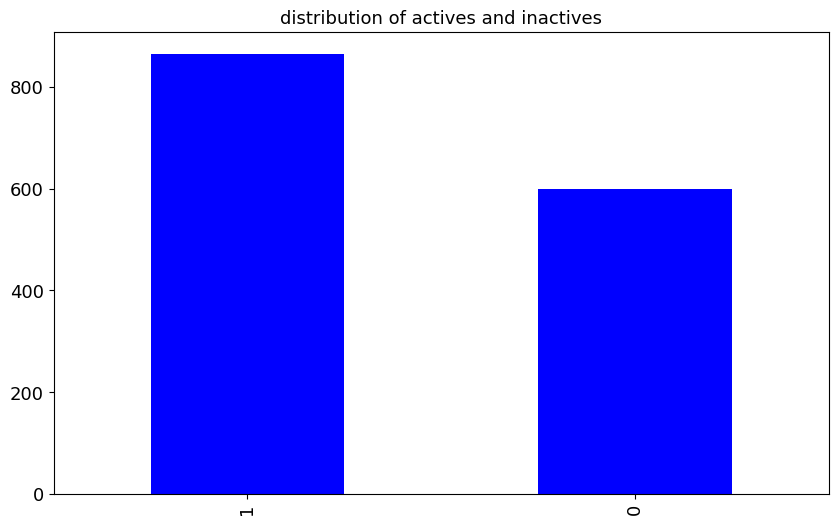

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [13]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validatee = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((1450, 606), (15, 777))

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

1    858
0    858
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

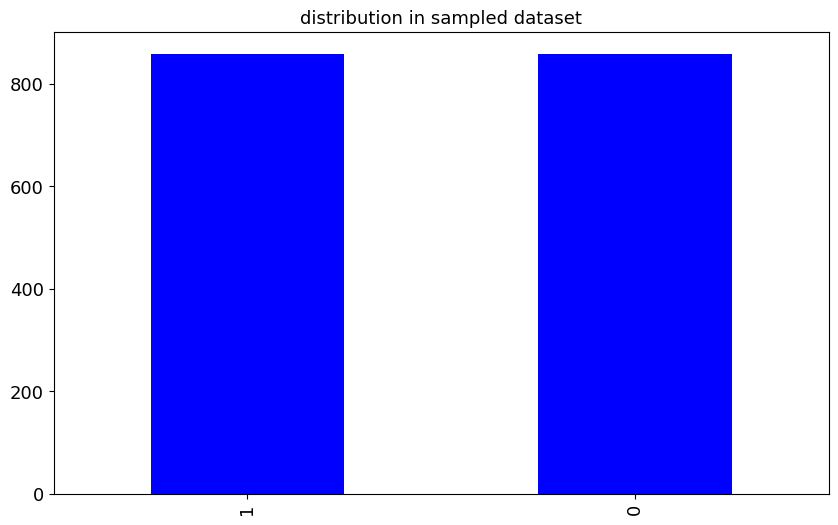

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
logistic_reg = LogisticRegression(solver='saga', max_iter=50, random_state=42, verbose=1, class_weight={0: 1, 1: 1.44})
logistic_reg.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds


c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


LogisticRegression(class_weight={0: 1, 1: 1.44}, max_iter=50, random_state=42,
                   solver='saga', verbose=1)

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

600

In [20]:
testing_data['activity'].value_counts()

1    300
0    300
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,5.087,0.343,0.240,0.314,1
1,0,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.087,-0.684,0.000,1.682,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.129,0.301,0.462,2.812,1
3,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.129,-0.323,0.231,1.792,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,5.000,-0.323,0.480,2.594,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

600


In [23]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [24]:
testing_data_x = testing_data_x.loc[:, mask]

In [25]:
testing_data_x.head()

,D001,D002,D003,D004,D005,D006,D007,D010,D012,D013,...,D764,D765,D768,D770,D771,D773,D774,D775,D776,D777
0,-0.702387,-0.069649,-0.037165,-1.029221,-0.244865,-0.135124,-0.045533,-0.02627,-0.393491,-0.932547,...,-0.142857,0.890054,-0.132174,1.266029,-0.264856,-0.06446,0.105758,0.803191,-0.710717,-1.466987
1,-2.063967,-0.069649,-0.037165,-1.029221,0.793306,-0.135124,-0.045533,-0.02627,-1.615253,1.142165,...,-0.142857,1.959298,-0.132174,1.266029,-0.264856,-0.06446,0.105758,-0.521984,-2.297137,-0.372719
2,0.659192,-0.069649,-0.037165,0.320119,-0.244865,-0.135124,-0.045533,-0.02627,0.583918,-0.413869,...,-0.142857,-1.248435,-0.132174,-0.593892,-0.264856,-0.06446,0.207635,0.748997,0.756721,0.531173
3,-0.702387,-0.069649,-0.037165,1.669459,-0.244865,-0.135124,-0.045533,-0.02627,-0.149139,0.623487,...,-0.142857,-0.179191,-0.132174,-0.593892,-0.264856,-0.06446,0.207635,-0.056173,-0.770208,-0.284729
4,0.659192,-0.069649,-0.037165,-1.029221,0.793306,-0.135124,-0.045533,-0.02627,0.095213,-0.413869,...,-0.142857,-1.248435,-0.132174,-0.593892,3.258456,-0.06446,-0.105273,-0.056173,0.875702,0.356794


In [26]:
logistic_reg.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [27]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [28]:
logistic_reg.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.5883333333333334

### evaluating model's performance with F1 score, precision, recall, etc

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
y_pred = logistic_reg.predict_proba(testing_data_x)[:, 1]
y_pred_rounded = (y_pred > 0.5).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


True

In [31]:
testing_data_y.shape == y_pred.shape

True

In [32]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [34]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.5883333333333334
precision is 0.5590200445434298
recall is 0.8366666666666667
f1 is 0.6702269692923898
